In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from matplotlib import cm
from matplotlib import colors as mcolors
from matplotlib.colors import rgb2hex
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import time
import datetime
import seaborn as sns; sns.set()
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import itertools
from itertools import groupby
from pyecharts.charts import Bar, Pie, Map, WordCloud, Geo
from pyecharts import options as opts
from snapshot_selenium import snapshot
from pyecharts.render import make_snapshot
from pyecharts.globals import ChartType, SymbolType
from pyecharts.commons.utils import JsCode
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK

import import_ipynb
from utils_common import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [11]:
# Where to save the dataframes and figures
_Figure_PATH_ = './figures/'

## Figures

In [6]:
# plot the confirmed cases
def figure_conf(df, figsize = (8,5), fs = 15, logy = False, title = None, rank = 0):
    
    sns.set_style("whitegrid")
    palette = plt.get_cmap('magma')
    
    fig = plt.figure()
    plot_df = df.groupby('update_date').agg('sum')
 
    ax1 = fig.add_subplot(111)
    plot_df.plot(y = ['cum_confirmed'], style = '-', marker = 'o', ax = ax1, 
                 figsize = figsize, logy = logy, color = palette(rank/50 + 0.2)) # grid = False, 
    ax1.set_ylabel("Number of people (cum)", fontsize = fs - 2)
    ax1.set_xticks([]) # hide the axes ticks
    plt.legend(loc = 'upper left', fancybox = True, fontsize = fs - 2)
    ax11 = ax1.twinx()
    ax11.bar(x = plot_df.index, height = plot_df['new_confirmed'], color = palette(rank/50 + 0.2), alpha = 0.8)
    
    ax11.set_ylabel('Number of people (daily)', fontsize = fs - 2)
    ax11.grid(False) # hide grid lines
    
    ax1.set_xlabel("Date", fontsize = fs - 2)
    
    daily_patch = mpatches.Patch(color = palette(rank/50 + 0.2), label='daily_confirmed')
    plt.legend(handles=[daily_patch], loc='upper left', bbox_to_anchor=(0, 0.9), fancybox=True, fontsize = fs - 2)

    if title is not None:
        fig.suptitle(title, fontsize = fs, y = 1)     
    return fig
    
# plot the confirmed, the dead, and the cured cases
def figure_conf_dead_cured(df, figsize=(10,8), fs=18, logy=False, title=None):
    
    sns.set_style("whitegrid")
    palette = plt.get_cmap('tab10')
    
    fig = plt.figure()
    plot_df = df.groupby('update_date').agg('sum')
 
    ax1 = fig.add_subplot(211)
    plot_df.plot(y = ['cum_confirmed'], style = '-', marker = 'o', ax = ax1, 
                 figsize = figsize, logy = logy, color = palette(3)) # grid = False, 
    ax1.set_ylabel("Number of people (cum)", fontsize = fs - 2)
    ax1.set_xticks([]) # hide the axes ticks
    plt.legend(loc='upper left', fancybox=True, fontsize = fs - 2)
    ax11 = ax1.twinx()
    ax11.bar(x = plot_df.index, height = plot_df['new_confirmed'], color = palette(3), alpha = 0.8)
    
    ax11.set_ylabel('Number of people (new)', fontsize = fs - 2)
    ax11.grid(False) # hide grid lines
    
    daily_patch = mpatches.Patch(color = palette(3), label='new_confirmed')
    plt.legend(handles=[daily_patch], loc='upper left', bbox_to_anchor=(0, 0.9), fancybox=True, fontsize = fs - 2)
    
    ax2 = fig.add_subplot(212)
    plot_df.plot(y = ['cum_dead', 'cum_cured'], style = '-', marker = 'o', ax = ax2,
                 figsize = figsize, sharex = False, logy = logy, color = [palette(1), palette(2)])
    ax2.set_xlabel("Date", fontsize = fs - 2)
    ax2.set_ylabel("Number of people", fontsize = fs - 2)
    
    ax1.set_xlim(min(df.update_date), max(df.update_date))
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    ax2.set_xlim(min(df.update_date), max(df.update_date))
    ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    plt.legend(loc='upper left', fancybox=True, fontsize = fs - 2)
    if title is not None:
        fig.suptitle(title, fontsize = fs, y=1) 
    fig.savefig(_Figure_PATH_ + 'China_' + 'conf_cured_dead.png', dpi = 400)
    return fig

# plot a specific column: confirmed, cured or dead
def figure_bar(df, date_str, col, groupby = 'province_name', largestN = 0, figsize = (12, 8), fs = 18, title = None):
    
    sns.set_style("whitegrid")
    year, month, day = date_str.split('-')
    
    date = datetime.date(int(year),int(month),int(day))
    if date_str is not None:
        df_date = df[df['update_date'] == date]
    else:
        df_date = df
        
    group_frm = df_date.groupby(groupby).agg('sum').sort_values(by = col, ascending = True)
        
    if largestN > 0:
        group_frm = group_frm[-largestN:]  # only plot the first N bars
    else:
        largestN = group_frm.shape[0]
        
    cmap_dict = {'cum_confirmed': 'Reds', 'new_confirmed': 'Reds', 
                 'cum_cured': 'Greens', 'new_cured': 'Greens', 
                 'cum_dead': 'Oranges', 'new_dead': 'Oranges'} 
        
    palette = plt.get_cmap(cmap_dict[col])
    
    fig, ax = plt.subplots()
    group_frm.plot.barh(y=col, grid=True, ax = ax, figsize = figsize, color = palette(np.linspace(0.2, 0.8, largestN)))
    ax.set_xlabel("Number of people", fontsize = fs - 2)
    ax.set_ylabel(groupby.capitalize()[:-8] + ' ' + groupby[-7:-3], fontsize = fs - 2)
    ax.set_yticklabels(group_frm.index, fontsize = fs - 4) 
    ax.set_xscale('log')
    #patch = mpatches.Patch(color = palette(0.8), label=col)
    #ax.legend(handles=[patch], loc='lower right', fancybox=True, fontsize = fs - 2)
    ax.get_legend().remove()
    
    if title is not None:
        #ax.set_title(title, fontproperties = _FONT_PROP_, fontsize = fs)  # because there is only one axes, so setting title on ax level, rather than the "suptitle" in figure level looks better
        ax.set_title(title + ' ' + col[:3] + ' ' + col[4:] + ' (' + date_str + ')', fontsize = fs)
    fig.savefig(_Figure_PATH_ + 'Province_' + col[4:] + '.png', dpi = 400)
    return fig

In [20]:
# plot the confirmed cases for every province
def figure_conf_all(df, names_province, fsize = (5, 3), ncol = 3, ms = 2, fs = 10, logy = False, 
                    title = None, country = 'China'):
    
    sns.set_style("ticks")
    palette = plt.get_cmap('Reds')
    
    m = len(names_province)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    
    df = data_province_domestic
    df_rank = df[df['update_date'] == max(df['update_date'])]
    df_rank = df_rank.sort_values(by = 'province_name_en') # same order as the list names_province
    df_rank = df_rank.reset_index(drop=True)
    df_rank = df_rank.sort_values(by = 'cum_confirmed')
    rank_list = df_rank.index.tolist()
    
    for i, province in enumerate(names_province):
        
        ix = np.unravel_index(i, axes.shape)
        c = palette(rank_list.index(i)/2/m + 0.3)
        
        plot_df = df[df['province_name_en'] == province]
        
        axes[ix].plot(plot_df['update_date'], plot_df['cum_confirmed'],
                linewidth = 2, marker = 'o', ms = ms, color = c, label = (lambda x: None if x > 0 else 'cum_confirmed')(i)) # 
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel('Date', fontsize = fs - 2)
            
        if i % ncol == 0:
            axes[ix].set_ylabel('Number of people (cum)', fontsize = fs - 2)
            axes[ix].get_yaxis().set_label_coords(-0.15,0.5)
        if i == 0:
            axes[ix].legend(loc = 'upper left', fancybox = True, fontsize = fs - 4)
        axes[ix].set_title(province, fontsize = fs)
     
    fig.align_ylabels(axes[:, 0])
    
    for i, province in enumerate(names_province):   
        ix = np.unravel_index(i, axes.shape)
        c = palette(rank_list.index(i)/2/m + 0.3)
        
        plot_df = df[df['province_name_en'] == province]
        ax11 = axes[ix].twinx()
        ax11.grid(False) # hide grid lines
        ax11.bar(plot_df['update_date'], height = plot_df['new_confirmed'], color = c, alpha = 0.8,
                label = (lambda x: None if x > 0 else 'new_confirmed')(i))
        daily_patch = mpatches.Patch(color = c, label='new_confirmed')
        if i == 0:
            ax11.legend(handles=[daily_patch], loc='upper left', bbox_to_anchor=(0, 0.86), fancybox=True, fontsize = fs - 4)
        ax11.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax11.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        if i % ncol == ncol - 1:
            ax11.set_ylabel('Number of people (new)', fontsize = fs - 2)
            ax11.get_yaxis().set_label_coords(1.15,0.5)
        
        axes[ix].set_xlim(min(df.update_date), max(df.update_date))
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
        
    fig.align_ylabels(axes[:, 2])    
    fig.suptitle(title, fontsize = fs + 2, y = 1.01)
    
    fig.savefig(_Figure_PATH_ + country + '_conf.png', dpi = 400)

🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄

In [12]:
# functions imported from utils_common
data_city, data_province, data_province_domestic = load_DXY_raw()

In [13]:
# the date is truncated to March 10, 2020
date_tr = datetime.date(int(2020),int(3),int(10))
data_province_domestic = data_province_domestic[data_province_domestic.update_date <= date_tr]

/Users/xingruchen/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


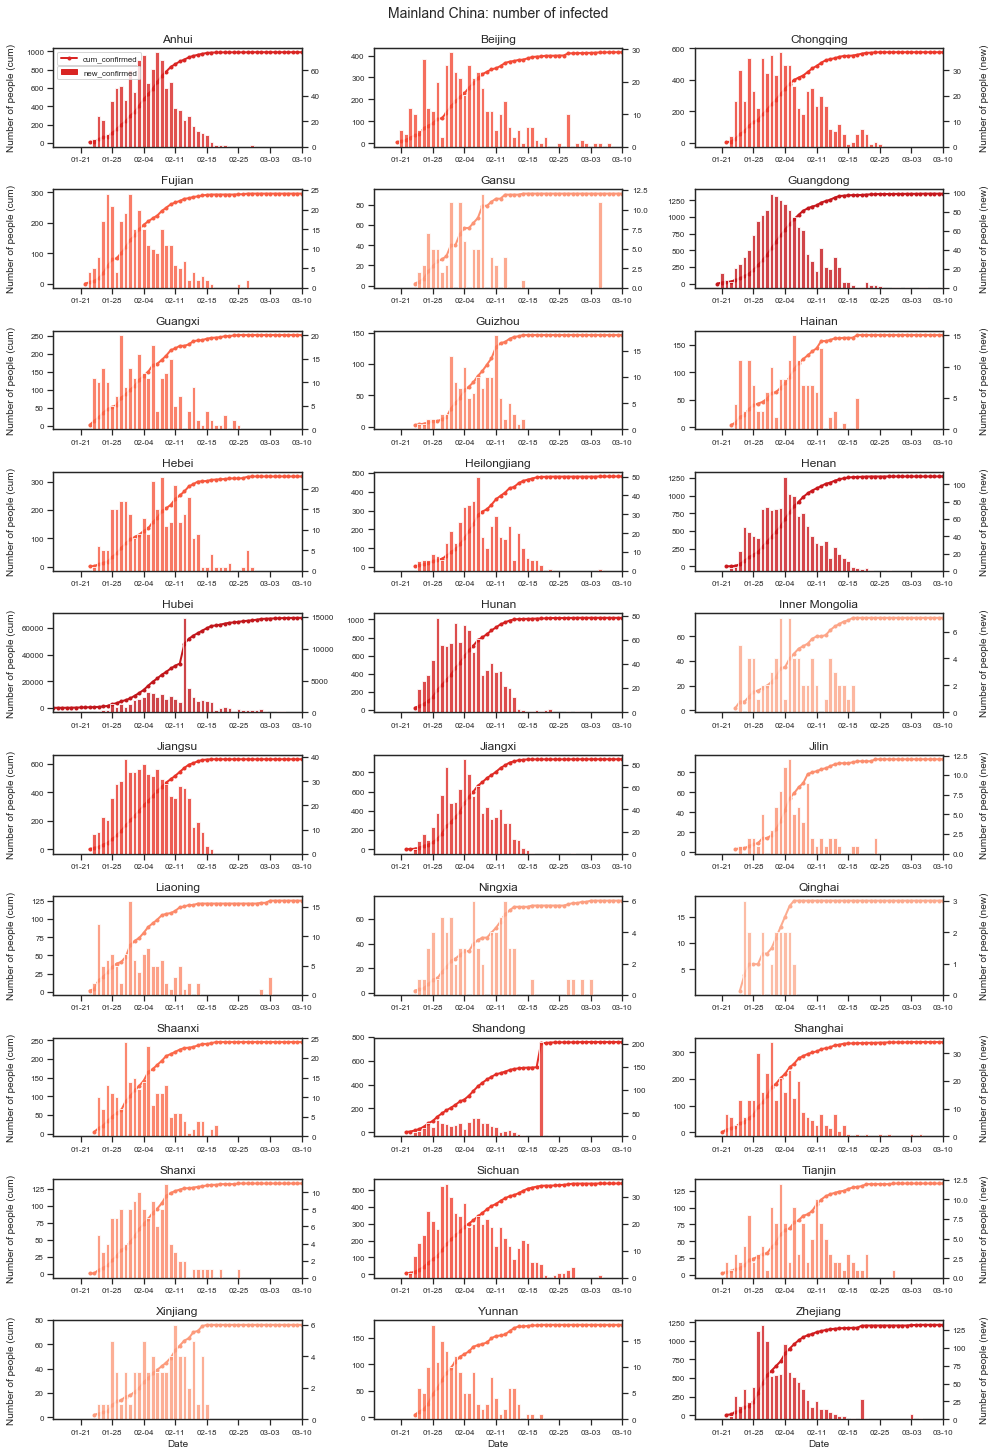

In [18]:
figure_conf_all(df = data_province_domestic, names_province = names_province, 
                fsize = (7, 2), ncol = 3, ms = 3, fs = 12, logy = False, 
                title = 'Mainland China: number of infected', country = 'China')

/Users/xingruchen/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


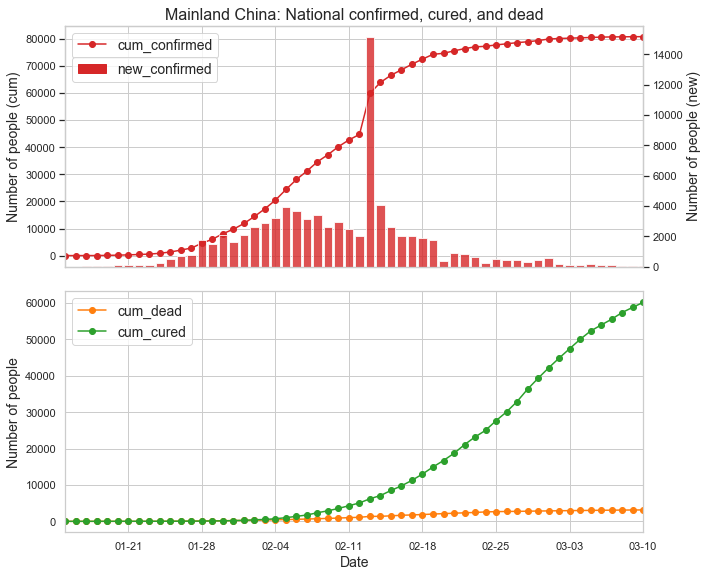

In [19]:
fig = figure_conf_dead_cured(data_province_domestic, figsize = (10,8), fs = 16, logy = False, title = 'Mainland China: National confirmed, cured, and dead')

In [1]:
#province = 'Hubei'   # target province
#fig = figure_conf_dead_cured(data_province[data_province['province_name_en'] == province], title = province + ': confirmed, cured, and dead')
#plt.show()

In [2]:
#city = 'Wuhan' # target city
#fig = figure_conf_dead_cured(data_city[data_city['city_name_en'] == city], logy = False, title = city + ': confirmed, cured, and dead')
#plt.show()  

/Users/xingruchen/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


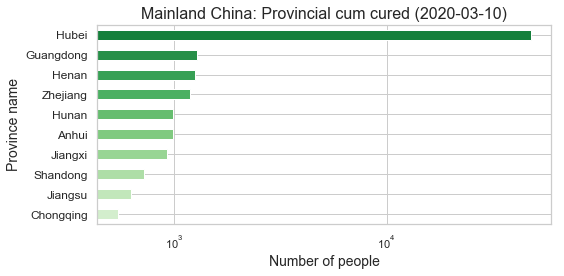

In [21]:
# province level
fig = figure_bar(df = data_province_domestic, date_str = '2020-03-10', 
                 col = 'cum_cured', groupby = 'province_name_en', 
                 largestN = 10, figsize = (8, 4), fs = 16, title = 'Mainland China: Provincial')

In [3]:
# city level
#fig = figure_bar(data_city, '2020-03-10', col = 'cum_confirmed', groupby = 'province_name_en',title = 'National')

In [5]:
#fig = figure_bar(data_city, '2020-03-10', col = 'new_confirmed', groupby = 'city_name_en', largestN = 10, title='Top 10 City')

In [4]:
# city level in Hubei province
#fig = figure_bar(data_city[data_city['province_name_en'] == 'Hubei'], '2020-02-01', col = 'cum_dead', groupby = 'city_name_en', title = 'Hubei Province')

In [23]:
# a dictionary for the pyecharts geo maps
d = {'湖北': 'Hubei',
 '广东': 'Guangdong',
 '河南': 'Henan',
 '浙江': 'Zhejiang',
 '湖南': 'Hunan',
 '安徽': 'Anhui',
 '江西': 'Jiangxi',
 '山东': 'Shandong',
 '江苏': 'Jiangsu',
 '重庆': 'Chongqing',
 '四川': 'Sichuan',
 '黑龙江': 'Heilongjiang',
 '北京': 'Beijing',
 '上海': 'Shanghai',
 '河北': 'Hebei',
 '福建': 'Fujian',
 '广西': 'Guangxi',
 '陕西': 'Shaanxi',
 '云南': 'Yunnan',
 '海南': 'Hainan',
 '贵州': 'Guizhou',
 '天津': 'Tianjin',
 '山西': 'Shanxi',
 '辽宁': 'Liaoning',
 '吉林': 'Jilin',
 '甘肃': 'Gansu',
 '新疆': 'Xinjiang',
 '宁夏': 'Ningxia',
 '内蒙古': 'Inner Mongolia',
 '青海': 'Qinghai'}
#for k, v in d.items():
    #print ('if(params.name == \'' + k + '\')' + '\n' + '    ' + 
                #'return \'' + v + '\' + \' : \' + ' + 'params.value[2];')

In [43]:
# geo maps
def figure_map(df, end_date, pieces, vr_upper = 0, fs = 20, subject = 'scatter'):
    
    data_single = df[df.update_date == end_date]
    data_single = data_single.sort_values(by='cum_confirmed', ascending=False)
    data_single = data_single.reset_index(drop=True)
    # for the scatter plot or heatmap
    provinces = data_single.province_name
    provinces = [pyecharts_province_dict[temp] for temp in provinces]
    values = data_single.cum_confirmed
    fn = """
    function(params) {
        return params.name + ' : ' + params.value[2]
    }
    """
    # show province names and values
    fn = """
    function(params) {
        if(params.name == '湖北')
            return 'Hubei' + ' : ' + params.value[2];
        if(params.name == '广东')
            return 'Guangdong' + ' : ' + params.value[2];
        if(params.name == '河南')
            return 'Henan' + ' : ' + params.value[2];
        if(params.name == '浙江')
            return 'Zhejiang' + ' : ' + params.value[2];
        if(params.name == '湖南')
            return 'Hunan' + ' : ' + params.value[2];
        if(params.name == '安徽')
            return 'Anhui' + ' : ' + params.value[2];
        if(params.name == '江西')
            return 'Jiangxi' + ' : ' + params.value[2];
        if(params.name == '山东')
            return 'Shandong' + ' : ' + params.value[2];
        if(params.name == '江苏')
            return 'Jiangsu' + ' : ' + params.value[2];
        if(params.name == '重庆')
            return 'Chongqing' + ' : ' + params.value[2];
        if(params.name == '四川')
            return 'Sichuan' + ' : ' + params.value[2];
        if(params.name == '黑龙江')
            return 'Heilongjiang' + ' : ' + params.value[2];
        if(params.name == '北京')
            return 'Beijing' + ' : ' + params.value[2];
        if(params.name == '上海')
            return 'Shanghai' + ' : ' + params.value[2];
        if(params.name == '河北')
            return 'Hebei' + ' : ' + params.value[2];
        if(params.name == '福建')
            return 'Fujian' + ' : ' + params.value[2];
        if(params.name == '广西')
            return 'Guangxi' + ' : ' + params.value[2];
        if(params.name == '陕西')
            return 'Shaanxi' + ' : ' + params.value[2];
        if(params.name == '云南')
            return 'Yunnan' + ' : ' + params.value[2];
        if(params.name == '海南')
            return 'Hainan' + ' : ' + params.value[2];
        if(params.name == '贵州')
            return 'Guizhou' + ' : ' + params.value[2];
        if(params.name == '天津')
            return 'Tianjin' + ' : ' + params.value[2];
        if(params.name == '山西')
            return 'Shanxi' + ' : ' + params.value[2];
        if(params.name == '辽宁')
            return 'Liaoning' + ' : ' + params.value[2];
        if(params.name == '吉林')
            return 'Jilin' + ' : ' + params.value[2];
        if(params.name == '甘肃')
            return 'Gansu' + ' : ' + params.value[2];
        if(params.name == '新疆')
            return 'Xinjiang' + ' : ' + params.value[2];
        if(params.name == '宁夏')
            return 'Ningxia' + ' : ' + params.value[2];
        if(params.name == '内蒙古')
            return 'Inner Mongolia' + ' : ' + params.value[2];
        if(params.name == '青海')
            return 'Qinghai' + ' : ' + params.value[2];
    }
    """
    # show only province names
    gn = """
    function(params) {
        if(params.name == '湖北')
            return 'Hubei';
        if(params.name == '广东')
            return 'Guangdong';
        if(params.name == '河南')
            return 'Henan';
        if(params.name == '浙江')
            return 'Zhejiang';
        if(params.name == '湖南')
            return 'Hunan';
        if(params.name == '安徽')
            return 'Anhui';
        if(params.name == '江西')
            return 'Jiangxi';
        if(params.name == '山东')
            return 'Shandong';
        if(params.name == '江苏')
            return 'Jiangsu';
        if(params.name == '重庆')
            return 'Chongqing';
        if(params.name == '四川')
            return 'Sichuan';
        if(params.name == '黑龙江')
            return 'Heilongjiang';
        if(params.name == '北京')
            return 'Beijing';
        if(params.name == '上海')
            return 'Shanghai';
        if(params.name == '河北')
            return 'Hebei';
        if(params.name == '福建')
            return 'Fujian';
        if(params.name == '广西')
            return 'Guangxi';
        if(params.name == '陕西')
            return 'Shaanxi';
        if(params.name == '云南')
            return 'Yunnan';
        if(params.name == '海南')
            return 'Hainan';
        if(params.name == '贵州')
            return 'Guizhou';
        if(params.name == '天津')
            return 'Tianjin';
        if(params.name == '山西')
            return 'Shanxi';
        if(params.name == '辽宁')
            return 'Liaoning';
        if(params.name == '吉林')
            return 'Jilin';
        if(params.name == '甘肃')
            return 'Gansu';
        if(params.name == '新疆')
            return 'Xinjiang';
        if(params.name == '宁夏')
            return 'Ningxia';
        if(params.name == '内蒙古')
            return 'Inner Mongolia';
        if(params.name == '青海')
            return 'Qinghai';
    }
    """
    # show only 5 province names and values
    hn = """
    function(params) {
        if(params.name == '湖北')
            return 'Hubei' + ' : ' + params.value[2];
        if(params.name == '广东')
            return 'Guangdong' + ' : ' + params.value[2];
        if(params.name == '河南')
            return 'Henan' + ' : ' + params.value[2];
        if(params.name == '浙江')
            return 'Zhejiang' + ' : ' + params.value[2];
        if(params.name == '湖南')
            return 'Hunan' + ' : ' + params.value[2];
        return '';
    }
    """
    # show only 5 province names
    ln = """
    function(params) {
        if(params.name == '湖北')
            return 'Hubei';
        if(params.name == '广东')
            return 'Guangdong';
        if(params.name == '河南')
            return 'Henan';
        if(params.name == '浙江')
            return 'Zhejiang';
        if(params.name == '湖南')
            return 'Hunan';
        return '';
    }
    """
    # scatter plot
    if subject == 'scatter':
        # show both province name and number of infected
        
        c = (
                Geo(init_opts = opts.InitOpts(width = '900px', height = '600px', bg_color = "#FFFFFF"),)
                .add_schema(maptype = "china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
                .add(
                    "number of infected",
                    [list(z) for z in zip(provinces, values)],
                    #type_= ChartType.EFFECT_SCATTER,
                    symbol_size = 10,
                    point_size = 5,
                )
                .set_series_opts(
                    label_opts = opts.LabelOpts(
                        formatter=JsCode(ln), font_size = fs - 8, color = 'black'))
                #.set_series_opts(label_opts = opts.LabelOpts(is_show = True))
                .set_global_opts(
                    legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs + 5)),
                    visualmap_opts = opts.VisualMapOpts(
                        is_show = True, split_number = 6, is_piecewise = True, pos_top = 'center',
                        pieces = pieces, textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                    title_opts = opts.TitleOpts(title = "China", subtitle = end_date.strftime("%d %B, %Y"),
                                               title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 10),
                                               subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs)))
            )
        
        make_snapshot(snapshot, c.render(), _Figure_PATH_ + "China_map.png")
        return c
    # heatmap plot
    else:
        c = (
            Geo(init_opts = opts.InitOpts(width = '900px', height = '600px', bg_color = "#FFFFFF"))
            .add_schema(maptype="china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
            .add(
                    "number of infected",
                    [list(z) for z in zip(provinces, values)],
                    #type_= ChartType.EFFECT_SCATTER,
                    symbol_size = 5,
                    point_size = 5,
                )
            .add(
                "number of infected",
                [list(z) for z in zip(provinces, values)],
                type_ = ChartType.HEATMAP,
                symbol_size = 15,  
            )
            .set_series_opts(label_opts = opts.LabelOpts(
                        formatter=JsCode(ln), font_size = fs - 8, color = 'black'))
            .set_global_opts(
                legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs + 5)),
                visualmap_opts = opts.VisualMapOpts(max_ = vr_upper, pos_top = 'center',
                                                   textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                title_opts = opts.TitleOpts(title="China",subtitle = end_date.strftime("%d %B, %Y"),
                                            title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 10),
                                            subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs + 5)))
        )
        c.render_notebook()
        make_snapshot(snapshot, c.render(), _Figure_PATH_ + "China_heatmap.png")
        return c

In [46]:
end_date = datetime.date(int(2020),int(3),int(10))
pieces = [{'min': 1001},  # no max for this
              {'min': 501, 'max': 1000},
              {'min': 201, 'max': 500},
              {'min': 101, 'max': 200},
              {'min': 51, 'max': 100},
              {'min': 0, 'max': 50}]
c = figure_map(data_province_domestic, end_date, pieces, fs = 20, subject = 'scatter')
c.render_notebook()

In [45]:
vr_upper = 800
c = figure_map(data_province_domestic, end_date, pieces, vr_upper, fs = 20, subject = 'heatmap')
c.render_notebook()